In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import joblib

In [125]:
df = pd.read_csv("../Dataset/df_processed.csv")
df.columns

Index(['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep',
       'ParentMaritalStatus', 'PracticeSport', 'IsFirstChild', 'NrSiblings',
       'School_Bus', 'WklyStudyHours', 'Grade'],
      dtype='object')

In [127]:
def group_val(outcome_group: int, group: int, outcome: int, total: int) -> float:
    """
    Calculate the expected value and chi-squared statistic for a subgroup.

    Parameters:
    outcome_group (int): The number of observed outcomes in the subgroup.
    group (int): The total number of individuals in the subgroup.
    outcome (int): The total number of observed outcomes across all groups.
    total (int): The total population size.

    Returns:
    float: The chi-squared statistic for the subgroup.
    """
    exp = group * outcome / total
    result = (outcome_group - exp) ** 2 / exp
    return result 

def chi_square(df: pd.DataFrame, protected_val: str, target: int) -> tuple:
    """
    Perform a chi-squared test to determine if there is a significant difference
    in the distribution of a binary target variable across a binary protected attribute.

    Parameters:
    df (DataFrame): A pandas DataFrame containing at least two columns: 
                    the protected attribute and the target variable.
    protected_val (str or int): The value of the protected attribute to test for bias.
    target (str or int): The target outcome to test for bias.

    Returns:
    tuple: A tuple containing the chi-squared statistic and the p-value.
    """
    pop_size = len(df)
    atributes = df.iloc[:, 0]
    preds = df.iloc[:, 1]

    protected_number = atributes.value_counts()[protected_val]
    unprotected_number = pop_size - protected_number

    positive_number = preds.value_counts()[target]
    negative_number = pop_size - positive_number

    positive_protected_number = len(df.loc[(preds == target) & (atributes == protected_val)])
    positive_unprotected_number = len(df.loc[(preds == target) & (atributes != protected_val)])
    negative_protected_number = len(df.loc[(preds != target) & (atributes == protected_val)])
    negative_unprotected_number = len(df.loc[(preds != target) & (atributes != protected_val)])

    statistic = (group_val(positive_protected_number, protected_number, positive_number, pop_size)
                 + group_val(positive_unprotected_number, unprotected_number, positive_number, pop_size)
                 + group_val(negative_protected_number, protected_number, negative_number, pop_size)
                 + group_val(negative_unprotected_number, unprotected_number, negative_number, pop_size))

    degrees_fred = len(atributes.unique()) - 1
    p_value = stats.chi2.sf(statistic, degrees_fred)
    return statistic, p_value


In [129]:
def plot_fpdp(model: joblib, data: pd.DataFrame, feature: str, fairness_feature: str, protected_val:str) -> None:
    """
    Plot a Fairness Partial Dependence Plot (FPDP) for the specified feature and fairness feature.

    Parameters:
    model (object): The trained machine learning model with a predict method.
    data (DataFrame): The dataset containing the features and target.
    feature (str): The name of the feature for which the FPDP is to be plotted.
    fairness_feature (str): The name of the feature to test for fairness.
    protected_val (str or int): The value of the protected attribute to test for bias.
    chi_square_func (function): Function to calculate chi-square statistics. 

    Returns:
    None: This function plots the FPDP and does not return any value.
    """
    # Get sorted unique values of the feature
    features = np.sort(data[feature].unique().tolist())
    
    p_vals = []
    features_plot = []

    # Iterate through each unique feature value and calculate chi-square statistic
    for feat in features:
        X_feature = data.loc[data[feature] == feat]
        predictions = pd.DataFrame(model.predict(X_feature), columns=['Predicted_Label'])
        result = pd.concat([X_feature[fairness_feature], predictions], axis=1)
        chi2_stat = chi_square(result, protected_val, 1)[1]

        features_plot.append(str(feat))
        p_vals.append(chi2_stat)
        
    # Plotting
    plt.bar(features_plot, p_vals)
    plt.axhline(y=0.05, color='r', linestyle='--')

    # Set title, axis labels, and legend
    plt.title(f"Fairness Partial Dependence Plot for '{feature}' by '{fairness_feature}'")
    plt.xlabel(f'{feature} Value')
    plt.ylabel('P-Value')
    plt.legend(['Significance Threshold (0.05)'])

    plt.tight_layout()
    plt.show()


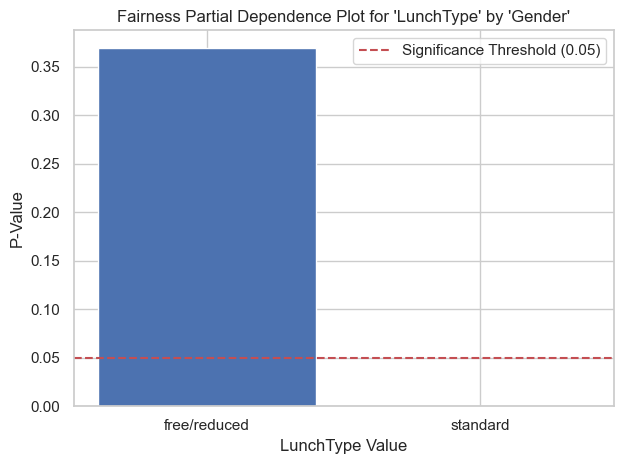

In [130]:
model = joblib.load('../Models/blackbox_model.pkl')
data = pd.read_csv('../Dataset/df_processed.csv')

#Plotting FPDP's 
plot_fpdp(model, data,"LunchType", "Gender", "male")